In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from tqdm import tqdm
import seaborn
import torch
import torch.nn as nn
BILICOUGH_ROOT = "E:/DATAS-Medical/BILIBILICOUGH/"

# explore

In [2]:
metadf = pd.read_csv(BILICOUGH_ROOT+"bilicough_metainfo.csv", delimiter=',', header=0, index_col=None, encoding="ansi")
print(metadf)
newdf = metadf
newdf["binlab"] = newdf["label"].apply(lambda x:2 if x==2 else 0)
newdf

           filename       st       en        labelfull labelname  label
0     bilicough_000  00:01.0  00:01.7            cough     cough      2
1     bilicough_000  00:01.7  00:02.2            cough     cough      2
2     bilicough_000  00:02.2  00:02.7            cough     cough      2
3     bilicough_000  00:03.0  00:03.4            cough     cough      2
4     bilicough_000  00:03.4  00:04.0            cough     cough      2
...             ...      ...      ...              ...       ...    ...
1266  bilicough_018  01:51.3  01:52.3         whooping  whooping     11
1267  bilicough_018  01:52.5  01:52.8  cough(whooping)     cough      2
1268  bilicough_018  01:52.8  01:53.1  cough(whooping)     cough      2
1269  bilicough_018  01:53.1  01:53.5  cough(whooping)     cough      2
1270  bilicough_018  01:54.1  01:55.4           speech    speech      9

[1271 rows x 6 columns]


,filename,st,en,labelfull,labelname,label,binlab
0,bilicough_000,00:01.0,00:01.7,cough,cough,2,2
1,bilicough_000,00:01.7,00:02.2,cough,cough,2,2
2,bilicough_000,00:02.2,00:02.7,cough,cough,2,2
3,bilicough_000,00:03.0,00:03.4,cough,cough,2,2
4,bilicough_000,00:03.4,00:04.0,cough,cough,2,2
...,...,...,...,...,...,...,...
1266,bilicough_018,01:51.3,01:52.3,whooping,whooping,11,0
1267,bilicough_018,01:52.5,01:52.8,cough(whooping),cough,2,2
1268,bilicough_018,01:52.8,01:53.1,cough(whooping),cough,2,2
1269,bilicough_018,01:53.1,01:53.5,cough(whooping),cough,2,2


<BarContainer object of 10 artists>

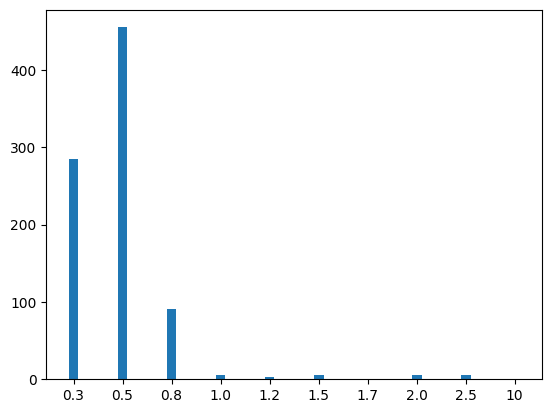

In [3]:
def min2sec(t: str):
    parts = t.split(':')
    res = float(parts[-1])
    f = 60
    for i in range(len(parts)-1):
        res += int(parts[len(parts)-2-i]) * f
        f *= 60
    return res
sn_list = []
sr = 22050
for ind, item in enumerate(metadf.itertuples()):
    # print("key:{},\tcount:{}, st:{}, en:{}, {}, {}".format(ind, item[1], item[2], item[3], item[5], item[6]))
    if item[6] == 2:
        st, en = int(min2sec(item[2])*sr), int(min2sec(item[3])*sr+1)
        sn = en - st
        sn_list.append((en - st)/22050)

# plt.hist(sn_list, bins=12)

trs = [0.3, 0.5, 0.8, 1.0, 1.2, 1.5, 1.7, 2.0, 2.5, 10]
cnt_list = [0] * len(trs)
for sn in sn_list:
    for i in range(len(trs)):
        if sn < trs[i]+0.1:
            cnt_list[i] += 1
            break
plt.figure(0)
plt.bar([str(item) for item in trs], cnt_list, width=0.2)

# Train Start

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
WAVE_ROOT = "G:/DATAS-Medical/BILIBILICOUGH/"
NOISE_ROOT = "G:/DATAS-Medical/BILINOISE/"
name2label = {"breathe":0, "cough":2,"clearthroat":1,"exhale":3, "hum":4, "inhale":5,"noise":6, "silence":7, "sniff":8,"speech":9, "vomit":10,"whooping":11}

In [2]:
def min2sec(t: str):
    parts = t.split(':')
    res = float(parts[-1])
    f = 60
    for i in range(len(parts)-1):
        res += int(parts[len(parts)-2-i]) * f
        f *= 60
    return res
def get_bilicough_dataset():
    metadf = pd.read_csv(WAVE_ROOT+"bilicough_metainfo.csv", delimiter=',', header=0, index_col=None, usecols=[0,1,2,5], encoding="ansi")
    print(metadf)
    cur_fname = None
    cur_wav = None
    data_length = None
    sample_list = []
    label_list = []
    sr_list = []
    pre_st, pre_en = None, None
    # filename	st	en	labelfull	labelname	label	binlab
    for ind, item in enumerate(metadf.itertuples()):
        if (cur_fname != item[1]) or (cur_fname is None):
            cur_fname = item[1]
            cur_wav, sr = librosa.load(WAVE_ROOT+cur_fname+".wav")
            if sr not in sr_list:
                sr_list.append(sr)
            data_length = sr
        st, en = int(min2sec(item[2])*sr), int(min2sec(item[3])*sr+1)
        if en > len(cur_wav):
            en = len(cur_wav)
        if en - st < 100:
            raise Exception("Error Index.")
        sn = en - st
        # sec = (en - st)/22050
        if (pre_en is None):
            if st >= data_length:
                st_pos = 0
                ind = 0
                while st_pos + data_length <= st:
                    # if len(cur_wav[st_pos:st_pos+data_length]) != sr:
                    #     raise Exception("Error Length.")
                    sample_list.append(cur_wav[st_pos:st_pos+data_length])
                    label_list.append(0)
                    st_pos += data_length
                    ind += 1
                    if ind >2:
                        break
                sample_list.append(cur_wav[st-data_length:st])
                label_list.append(0)
        else:
            if st - pre_en >= sr:
                st_pos = pre_en
                ind = 0
                while st_pos + data_length <= st:
                    # if len(cur_wav[st_pos:st_pos+data_length]) != sr:
                    #     raise Exception("Error Length.")
                    sample_list.append(cur_wav[st_pos:st_pos+data_length])
                    label_list.append(0)
                    st_pos += data_length
                    ind += 1
                    if ind > 2:
                        break
                sample_list.append(cur_wav[st-data_length:st])
                label_list.append(0)
        label = int(item[4])
        if sn==data_length:
            # if len(cur_wav[st:en]) != sr:
            #     raise Exception("Error Length.")
            sample_list.append(cur_wav[st:en])
            if label in [6, 7]:
                label_list.append(0)
            else:
                label_list.append(1)
        elif sn < data_length:
            new_sample = np.zeros(data_length)
            # print(st, en, sn, len(cur_wav), item[1])
            if en <= len(cur_wav):
                new_sample[:sn] = cur_wav[st:en]
            else:
                new_sample[:sn] = cur_wav[len(cur_wav)-sn:len(cur_wav)]
            # if len(new_sample) != sr:
            #     raise Exception("Error Length.")
            sample_list.append(new_sample)
            if label in [6, 7]:
                label_list.append(0)
            else:
                label_list.append(1)
        else:
            cnt_sum = sn // data_length + 1
            res = cnt_sum * data_length - sn
            overlap = res // (cnt_sum-1)
            st_pos = st
            while st_pos + data_length < en:
                # if len(cur_wav[st_pos:st_pos+data_length]) < data_length: 
                #     tmp_length = len(cur_wav[st_pos:st_pos+data_length])
                #     print(data_length, tmp_length)
                #     # raise Exception("Error Length.")
                #     print("Error Length.")
                #     new_sample = np.zeros(data_length)
                #     new_sample[:tmp_length] = cur_wav[st_pos:st_pos+data_length]
                #     sample_list.append(new_sample)
                # else:
                #     sample_list.append(cur_wav[st_pos:st_pos+data_length])  
                sample_list.append(cur_wav[st_pos:st_pos+data_length])                
                if label in [6, 7]:
                    label_list.append(0)
                else:
                    label_list.append(1)
                st_pos += data_length - overlap
            sample_list.append(cur_wav[en-data_length:en])
            label_list.append(1)
        pre_st, pre_en = st, en
    print("sound count:{}, all count:{}.".format(sum(label_list), len(label_list)))
    print("sample rate of waveform:", sr_list)
    return sample_list, label_list
# 添加噪声数据
def load_bilinoise_dataset(noise_length=22050, number=1):
    # noise_length = None
    filter_length = 25
    new_noise_list = []
    new_label_list = []
    flist = []
    for item in os.listdir(NOISE_ROOT):
        if item[-4:] == ".wav" and len(item)>=filter_length:
            flist.append(item)
    random.shuffle(flist)
    ind = 0
    for item in flist:
        cur_fname = NOISE_ROOT+item
        cur_wav, sr = librosa.load(cur_fname)
        noise_length = sr
        L = len(cur_wav)
        st_pos = np.random.randint(0, L-noise_length)
        new_noise_list.append(cur_wav[st_pos:st_pos+noise_length])
        new_label_list.append(0)
        # print(NOISE_ROOT+item)
        ind += 1
        if ind == number:
            break
    return new_noise_list, new_label_list
def addnoise(w, a):
    if len(w) != len(a):
        raise ValueError("The length of waveform and noise are not equal, and can't be added together!")
    return w+a

### 读取数据

In [ ]:
sample_list, label_list = get_bilicough_dataset()
length_list = []
for item in sample_list:
    if len(item) not in length_list:
        length_list.append(len(item))
print("length of sample:", length_list)

data_length = length_list[0]
print("data length:", data_length)

### 创建新的数据平衡标签数 

In [5]:
diff_num = 2*sum(label_list) - len(label_list)
print("need new negative sample of number {}".format(diff_num))
if diff_num > 0:
    new_noise_list, new_label_list = load_bilinoise_dataset(noise_length=data_length, number = diff_num)
    sample_list.extend(new_noise_list)
    label_list.extend(new_label_list)
elif diff_num < 0:
    # 正样本少就无所谓了
    pass
print("number of wave {} and label {}.".format(len(sample_list), len(label_list)))
print("number of positive sample {} and label {}.".format(len(label_list), sum(label_list)))

need new negative sample of number 970
number of wave 2796 and label 2796.


# Cheak End, Detection Start

# 创建神经网络

## 注意到，频域决定类别、幅值和时长是干扰因素，因为想办法在这里入手
### 频域多用全连接而不是卷积池化
### 幅值多用normalization
### 时长采用多尺度叠加

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
# sys.path.append(r'D:/PythonTorchVITS/MedicalSignal/SoundDL-CoughVID')
sys.path.append(r'C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID')
from chapter2_VADmodel import VADModel
save_dir = "./runs/c2vadmodel/"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vad_model = VADModel()
vad_model.load_state_dict(torch.load(save_dir+"202502141500/vad_model_epoch30.pth"))
vad_model.to(device)
vad_model.eval()

The first Layer of the TDNN: kernel_size:1024, stride:488, padding:512
Build TDNN Extractor with 6 Conv1d Layers.


VADModel(
  (mel_extractor): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (wave_conv): TDNN_Extractor(
    (wav2mel): Conv1d(1, 128, kernel_size=(1024,), stride=(488,), padding=(512,), bias=False)
    (layer_norm): LayerNorm((46,), eps=1e-05, elementwise_affine=True)
    (td_layer1): Conv1d(128, 512, kernel_size=(5,), stride=(1,))
    (bn1): LayerNorm((42,), eps=1e-05, elementwise_affine=True)
    (td_layer2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(2,), groups=512)
    (bn2): LayerNorm((38,), eps=1e-05, elementwise_affine=True)
    (td_layer3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), dilation=(3,), groups=512)
    (bn3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (td_layer4): Conv1d(512, 512, kernel_size=(1,), stride=(1,), groups=512)
    (bn4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (td_layer5): Conv1d(512, 1024, kernel_size=(1,), stride=(1,), groups=512)
    (leakyrelu): LeakyReLU(negativ

In [29]:
# WAVE_ROOT = "G:/DATAS-Medical/BILIBILICOUGH/"
# testwav, sr = librosa.load(WAVE_ROOT+"bilicough_009.wav")
testwav, sr = librosa.load("F:/DATAS/NEUCOUGHDATA_FULL/20240921133332_audiodata_元音字母a.wav")
N = len(testwav)
maxv = max(testwav)
seg_list = []
st, step, overlap = 0, 22050, 22050//3
while st+step<=N:
    seg_list.append(testwav[st:st+step])
    st = st+step-overlap
tmp = testwav[st:]
new_tmp = np.zeros(step)
st = (step-len(tmp))//2
new_tmp[st:st+len(tmp)] = tmp
seg_list.append(new_tmp)
print(len(seg_list))

seg_list = [torch.from_numpy(it) for it in seg_list]

batch_size = 32
x_batchs = []
ind = 0
while ind+batch_size < len(seg_list):
    x_batchs.append(torch.stack(seg_list[ind:ind+batch_size], dim=0))
    ind += batch_size
x_batchs.append(torch.stack(seg_list[ind:], dim=0))
print("batch num:{}, batch shape:{}".format(len(x_batchs), x_batchs[0].shape))

273
batch num:9, batch shape:torch.Size([32, 22050])


In [31]:
pred_list = None
for batch_id, x_wav in enumerate(x_batchs):
    with torch.no_grad():
        y_pred = vad_model(x=x_wav.to(device).unsqueeze(1).to(torch.float32))
        if pred_list is None:
            pred_list = y_pred
        else:
            pred_list = torch.concat((pred_list, y_pred), dim=0)
pred_list = np.argmax(pred_list.data.cpu().numpy(), axis=1)

In [32]:
pred_list

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [18]:
from copy import copy

In [35]:
print("data_length:", pred_list)
new_pred = copy(pred_list)
flag = False
for i in range(len(pred_list)):
    if pred_list[i] > 0:
        if not flag:
            new_pred[i-1:i+1] = 1
            flag = True
        else:
            continue
    else:
        if flag:
            new_pred[i:i+1] = 1
            # new_pred[i+1] = 0
            flag = False
        else:
            continue
for i in range(len(pred_list)-1):
    new_pred[i] = new_pred[i+1]
new_pred[-1] = 0
new_pred = new_pred*maxv


data_length: [0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0
 0 0 1 0 1 1 0 0 0 0 0 0 0 0]


4020194 4020198


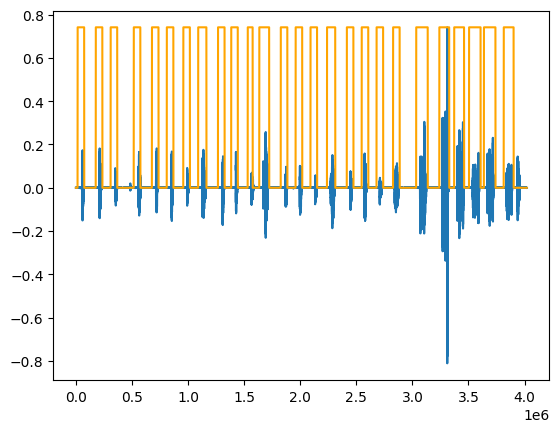

In [37]:
plt.figure(1)
sig_len = N // len(pred_list)+1
curve = []
for it in new_pred:
    curve.extend([it]*(sig_len))
    
print(N, len(curve))

plt.plot(range(N), testwav)
plt.plot(range(len(curve)), curve, c="orange")

plt.savefig(save_dir+"202502141500/vad_detection_neu20240921133332.png", dpi=300, format="png")

# End Detection